In [1]:
%load_ext cython

In [2]:
import numpy as np
np.random.seed(42)
n = int(64 * 1024 * 1024)
a = np.random.randint(0, high=1000, size=n)
b = np.random.randint(0, high=1000, size=n)
c = np.random.randint(0, high=1000, size=n)
d = np.random.randint(0, high=1000, size=n)
a

array([102, 435, 860, ..., 575, 912, 589])

# Skips

In [3]:
%%cython -a
# cython: boundscheck = False

cpdef A(long[:] x):
    cdef int i, n = x.shape[0]
    for i in range(0, n, 1):
        x[i] *= 3

        
cpdef B(long[:] x):
    cdef int i, n = x.shape[0]
    for i in range(0, n, 16):
        x[i] *= 3


cpdef C(long[:] x, int step):
    cdef int i, n = x.shape[0]
    #for i in range(0, n, step):
    for i from 0 <= i < n by step:
        x[i] *= 3


In [4]:
%timeit A(a)
%timeit B(a)
%timeit C(a, 16)

The slowest run took 8.03 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 54.1 ms per loop
10 loops, best of 3: 40.5 ms per loop
10 loops, best of 3: 42.7 ms per loop


# Speed is the same UNTIL the cache misses

In [5]:
%timeit C(a, 1)
%timeit C(a, 2)
%timeit C(a, 3)
%timeit C(a, 4)
%timeit C(a, 5)
%timeit C(a, 6)
%timeit C(a, 7)
%timeit C(a, 8)
%timeit C(a, 16)
%timeit C(a, 32)
%timeit C(a, 64)
%timeit C(a, 128)

10 loops, best of 3: 87.3 ms per loop
10 loops, best of 3: 57.8 ms per loop
10 loops, best of 3: 55.3 ms per loop
10 loops, best of 3: 55.5 ms per loop
10 loops, best of 3: 55.4 ms per loop
10 loops, best of 3: 55.6 ms per loop
10 loops, best of 3: 55.2 ms per loop
10 loops, best of 3: 55.9 ms per loop
10 loops, best of 3: 40.5 ms per loop
10 loops, best of 3: 22 ms per loop
100 loops, best of 3: 10 ms per loop
100 loops, best of 3: 5.08 ms per loop


# Spills

In [6]:
%%cython -a
# cython: boundscheck = False

cpdef spill(long[:] a):
    cdef int i, n = a.shape[0]
    cdef int lengthMod = n - 1
    for i in range(64 * 1024 * 1024):
        a[(i * 16) & lengthMod] += 1


In [10]:
from contextlib import contextmanager
from time import perf_counter

@contextmanager
def p(fun):
    t0 = perf_counter()
    yield
    t1 = perf_counter()
    fun(t1 - t0)
   
    
#steps = [2**x * 1024 for x in range(21)]

size = [2**x * 1024 for x in range(21)]
#size = [2 * x * 1024 for x in range(1, 11)]
print(size[:3], size[:3])
result = []

for n in size:
    a = np.random.randint(0, 1000, n)
    def apnd(timing):
        result.append((n//1024, timing*1e3, timing*1e9/(64 * 1024 * 1024)))
    with p(apnd):
        spill(a)
    
%matplotlib inline
    
times = []
sizes = []
for e in result:
    print('{:16d} kB. Timing: {:.4f} ms  Time/element: {:>10.4f}'.format(
            e[0], e[1], e[2]))
    
    options = [
        ('{:.4g} min', 1/60), 
        ('{:.4g} s', 1),
        ('{:.4g} ms', 1e3),
        ('{:.4g} us', 1e6), 
        ('{:.4g} ns', 1e9)
    ]
    
    fmts = [x[0].format(e[2] * x[1]) for x in options]
    selected = fmts[0]
    for f in fmts:
        if not 'e' in f:
            selected = f
    times.append(e[2])
    
    
    options = [
        ('{:.4g} kB', 1), 
        ('{:.4g} MB', 1/1024),
        ('{:.4g} GB', 1/1024/1024),
    ]
    
    fmts = [x[0].format(e[0] * x[1]) for x in options]
    selected = fmts[0]
    for f in fmts:
        #print(f)
        if not 'e' in f:
            selected = f
            break
    
    sizes.append(selected)
    
print(sizes)
    


[1024, 2048, 4096] [1024, 2048, 4096]
               1 kB. Timing: 83.0375 ms  Time/element:     1.2374
               2 kB. Timing: 73.7398 ms  Time/element:     1.0988
               4 kB. Timing: 70.4286 ms  Time/element:     1.0495
               8 kB. Timing: 127.3535 ms  Time/element:     1.8977
              16 kB. Timing: 129.6952 ms  Time/element:     1.9326
              32 kB. Timing: 132.3864 ms  Time/element:     1.9727
              64 kB. Timing: 174.8932 ms  Time/element:     2.6061
             128 kB. Timing: 177.2287 ms  Time/element:     2.6409
             256 kB. Timing: 176.8967 ms  Time/element:     2.6360
             512 kB. Timing: 251.9131 ms  Time/element:     3.7538
            1024 kB. Timing: 432.5997 ms  Time/element:     6.4462
            2048 kB. Timing: 515.4590 ms  Time/element:     7.6809
            4096 kB. Timing: 589.2455 ms  Time/element:     8.7804
            8192 kB. Timing: 623.3236 ms  Time/element:     9.2882
           16384 kB. Timing

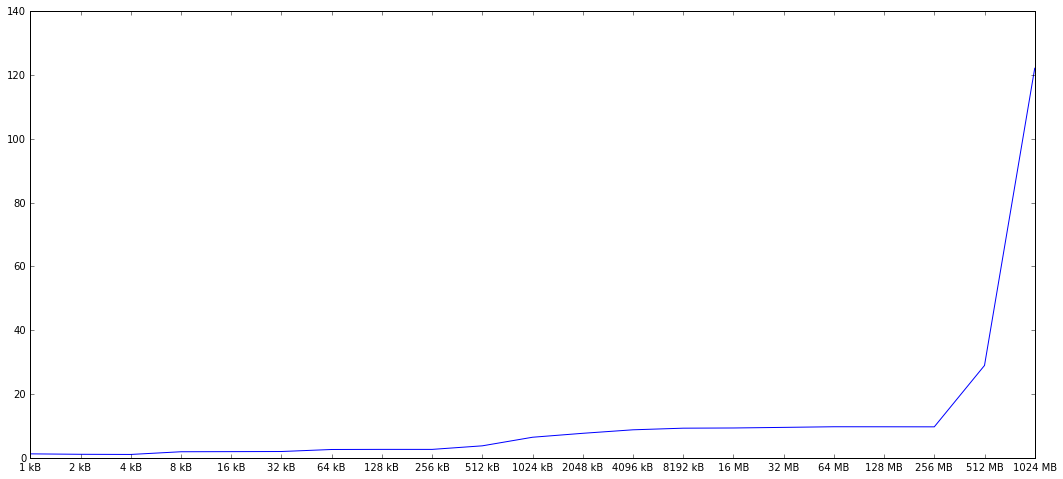

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))

n = len(sizes)
plt.plot(range(n), times)
plt.xticks(range(n), sizes)
#plt.xscale('log', basex=2)
plt.show()

In [ ]:
'{:.4g}'.format(12341320.0000000323)

# Instruction-level parallelism

In [ ]:
%%cython -a
cdef int steps = 256 * 1024 * 1024 * 10000000
cdef int a[2]
a[:] = [0, 0]

cpdef loop1():
    cdef int i
    for i in range(steps):
        a[0] += 1
        a[0] += 1

cpdef loop2():
    cdef int i
    for i in range(steps):
        a[0] += 1
        a[1] += 1

In [ ]:
%timeit loop1()
%timeit loop2()

# Cache Associativity